# Automatic Analysis of XAS *In-Situ* Data w. Measured Standards
Notebook showing an example workflow used for automatic analysis of XAS *in-situ* data when standards for both unreduced precursors and reduced metal foils have been measured on the same instrument.

# Imports
Here the required packages and functions are imported.

Whether plots are interactive is also changed here. 

In [1]:
# Functions written for the analysis of XAS data
from autoXAS.data import *
from autoXAS.analysis import *
from autoXAS.plotting import *

%matplotlib inline

# Global variables

In [2]:
synchrotron = 'SNBL'

# Boolean flags
Here the values of boolean flags (True/False) that occur throughout the notebook can be changed.

In [3]:
# Decide if transmission or absorption data should be used for normalization and analysis
use_transmission = False
# Decide if subtraction of pred-edge should be used for normalization
use_preedge = True
# Decide if plots should be interactive or static
interactive = True

# Splitting of .dat files
Split .dat files containing multiple measurements into single measurement files

In [4]:
# split_dat_file(
#     data_folder='../Data/ESRF_BM31/IrPtPdRuRh_XAS/IrPtPdRuRh_XAS/XAS1/',
#     filename='Pd',
#     header_length=81,
#     data_length=161, # This value will most likely be different for each measured edge
#     footer_length=5,
# )

# Standards and preprocessing
Here the measured standards (metal foils and precursors) are loaded and preprocessed. 

This section only needs to be run once, as it applies to all experiments measured on the same instrument.

## Metal foils

In [9]:
# Specify data location
folder_metal_foils = '../Data/ESRF_SNBL/NormalizeDataProblem/'

# Load data
df_foils = load_xas_data(
    folder_metal_foils,
    synchrotron=synchrotron, 
    file_selection_condition='Foil', # It will look for files with this substring in the filename. This can also be a list of substrings
    negated_condition=False, # Files containing the above substring will be ignored(True)/loaded(False).
)

# Initial data processing
df_foils = processing_df(df_foils, synchrotron=synchrotron)

# Specify the measurements to use when averaging. 
# This can be given as either a list or a range.
# measurements_to_average = range(1,3) # Change this to fit the number of repeat measurements for the standards

# Create dataframe with the reference spectra for reduced metals
# df_foils = average_measurements(df_foils, measurements_to_average)

Loading data: 100%|██████████| 6/6 [00:00<00:00, 23.46it/s, Currently loading PtFoil_Pt_exafs.dat]


### Edge energy corrections
The energy shifts of the different edges are systematic errors from the instrument. Therefore the shift is consistent across measurements and we can correct the measured data using the theoretical edge energies.

In [6]:
# # Calculate the edge energy shift at each edge
# edge_correction_energies = {
#     'Pd':calc_edge_correction(df_foils, metal='Pd', edge='K', transmission=use_transmission),
#     'Ag':calc_edge_correction(df_foils, metal='Ag', edge='K', transmission=use_transmission),
#     'Rh':calc_edge_correction(df_foils, metal='Rh', edge='K', transmission=use_transmission),
#     'Ru':calc_edge_correction(df_foils, metal='Ru', edge='K', transmission=use_transmission),
#     'Mn':calc_edge_correction(df_foils, metal='Mn', edge='K', transmission=use_transmission),
#     'Ir':calc_edge_correction(df_foils, metal='Ir', edge='L3', transmission=use_transmission),
#     'Pt':calc_edge_correction(df_foils, metal='Pt', edge='L3', transmission=use_transmission),
# }

# Use dictionary filled with 0's if no foils have been measured
edge_correction_energies = {
    'Pd':0,
    'Ag':0,
    'Rh':0,
    'Ru':0,
    'Mn':0,
    'Ir':0,
    'Pt':0,
    'Co':0,
    'Fe':0,
    'Ni':0,
    'Au':0,
}


### Normalization
Normalization includes correcting the energy shifts, subtraction by the minimum measured value and division by a fit to the post-edge data. A fit to the pre-edge data can also be used to subtract from the data, but can sometimes lead to overcorrections. 

The pre- and post-edge fits can be visually inspected using the "plot_non_normalized_xas()" function with the optional arguments "pre_edge=True" and "post_edge=True". 

All normalization of data **must** use the same normalization procedure!

In [17]:
df_foils.describe()

Measurement     ZapEnergy  xmap_roi00         mon_3         mon_4  \
count  22088.000000  22088.000000     22088.0  22088.000000  22088.000000   
mean       1.500000     12.363124         0.0   3698.197754   7758.964355   
std        0.500011      6.681201         0.0   7868.480957   4096.852051   
min        1.000000      7.010096         0.0      0.000000      4.000000   
25%        1.000000      7.974161         0.0      0.000000   7259.000000   
50%        1.500000      8.755663         0.0      0.000000  10071.500000   
75%        2.000000     12.258152         0.0      0.000000  10771.000000   
max        2.000000     26.496826         0.0  26670.000000  11470.000000   

             Energy  Temperature  Flourescence  Transmission  Relative Time  \
count  22088.000000      22088.0       22088.0       22088.0        22088.0   
mean   12363.123047          0.0           0.0           0.0            0.0   
std     6681.200684          0.0           0.0           0.0            0.0   
min     7010.095703          0.0           0.0           0.0            0.0   
25%     7974.161011          0.0           0.0           0.0            0.0   
50%     8755.663086          0.0           0.0           0.0            0.0   
75%    12258.152344          0.0           0.0           0.0            0.0   
max    26496.826172          0.0           0.0           0.0            0.0   

       Energy_Corrected  Normalized  pre_edge  post_edge  
count           22088.0     22088.0   22088.0    22088.0  
mean                0.0         0.0       0.0        0.0  
std                 0.0         0.0       0.0        0.0  
min                 0.0         0.0       0.0        0.0  
25%                 0.0         0.0       0.0        0.0  
50%                 0.0         0.0       0.0        0.0  
75%                 0.0         0.0       0.0        0.0  
max                 0.0         0.0       0.0        0.0

In [11]:
df_foils['xmap_roi00'][df_foils['Metal'] == 'Pd'].to_numpy() / df_foils['mon_3'][df_foils['Metal'] == 'Pd'].to_numpy()

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [8]:
# Normalization of the data
normalize_data(
    df_foils, 
    edge_correction_energies, 
    subtract_preedge=use_preedge, 
    transmission=use_transmission,
    
)
df_foils.head()

Normalization progress:   0%|          | 0/6 [00:00<?, ?it/s]

AgFoil_Ag_exafs
Ag


Normalization progress:  17%|█▋        | 1/6 [00:00<00:00, 20.79it/s]


1
0.0
0       0
1       0
2       0
3       0
4       0
       ..
1095    0
1096    0
1097    0
1098    0
1099    0
Name: Normalized, Length: 1100, dtype: int64
Error occurred during normalization of data from measurement 1. The error is most likely due to the measurement being stopped before completion.
The measurement (incl. all edges) has therefore been removed from the dataset and measurement numbers are corrected.
1
0.0
1100    0
1101    0
1102    0
1103    0
1104    0
       ..
2195    0
2196    0
2197    0
2198    0
2199    0
Name: Normalized, Length: 1100, dtype: int64
Error occurred during normalization of data from measurement 1. The error is most likely due to the measurement being stopped before completion.
The measurement (incl. all edges) has therefore been removed from the dataset and measurement numbers are corrected.
CoFoil_Co_exafs


IndexError: list index out of range

### Plotting
It is always a good idea to visually inspect the data to see if it behaves as it should.

In [ ]:
# plot_non_normalized_xas(df_foils, 'Pdfoil', pre_edge=True, post_edge=True, transmission=use_transmission, interactive=interactive)

## Precursors

In [ ]:
# # Specify data loccation
# folder_precursor_standards = '../Data/ESRF_BM31/wheel/wheel/'

# # Load data
# df_precursors = load_xas_data(
#     folder_precursor_standards, 
#     synchrotron='ESRF', 
#     file_selection_condition='mono', 
#     negated_condition=True,
# )

# # Initial data processing
# df_precursors = processing_df(df_precursors, synchrotron='ESRF')

# # Specify the measurements to use when averaging. 
# # This can be given as either a list or a range.
# measurements_to_average = range(1,3)

# # Create dataframe with the reference spectra for reduced metals
# df_precursors = average_measurements(df_precursors, measurements_to_average)

### Normalization

In [ ]:
# # Normalization of the data
# normalize_data(
#     df_precursors, 
#     edge_correction_energies, 
#     subtract_preedge=use_preedge, 
#     transmission=use_transmission
# )
# df_precursors.head()

### Plotting
It is always a good idea to visually inspect the data to see if it behaves as it should.

In [ ]:
# plot_non_normalized_xas(df_precursors, 'Pdacac', pre_edge=True, post_edge=True, transmission=use_transmission, interactive=interactive)

# Experiments
Here the measured data from different experiments are loaded, preprocessed and analysed. 

This section needs to be run every time a new experiment is analysed.

## Preprocessing

### Single dataset
Use either this section or *Stiching together datasets*.

In [ ]:
# Specify data location
folder_XAS_data = '../Data/ESRF_SNBL/Averaging/'

# # Load data
# df_data = load_xas_data(
#     folder_XAS_data, 
#     synchrotron=synchrotron, 
#     file_selection_condition='xanes', 
#     negated_condition=False,
#     keep_incomplete=True,
# )
# # print(df_data.head())
# # Initial data processing
# df_data = processing_df(df_data, synchrotron=synchrotron)

In [ ]:
folder_XAS_data = '../Data/ESRF_SNBL/Averaging/'
df_data = load_and_prepare_data(
    folder_XAS_data,
    energy_column='ZapEnergy',
    I0_columns=['mon_3', 'mon_4'],
    I1_columns='xmap_roi00',
    metal=('_',-2),
    energy_column_unitConversion=1000,
    xas_mode='Flourescence',
    extract_time=False,
    # time_skipLines=28,
    # time_startTag='#D ',
    # time_endTag='#C ',
    file_selection_condition='xanes',
    negated_condition=False,
    keep_incomplete=True,
)

Loading data: 100%|██████████| 4/4 [00:00<00:00,  4.37it/s, Currently loading PtFeCoNi_60pct_insitu_Pt_xanes.dat]


Incomplete measurement detected!
Not all edges were measured 48 times, but only 32 times.
Incomplete measurements will be removed unless keep_incomplete="True".


In [ ]:
df_data = average_measurements_periodic(
    df_data,
    period=None,
    n_periods=16,
)

### Stiching together datasets
Use either this section or *Single dataset*.

In [ ]:
# # Specify all data locations
# list_of_folders = [
#     '../Data/ESRF_BM31/IrPtPdRuRh_XAS/IrPtPdRuRh_XAS/XAS1/',
#     '../Data/ESRF_BM31/IrPtPdRuRh_XAS/IrPtPdRuRh_XAS/XAS2/',
#     '../Data/ESRF_BM31/IrPtPdRuRh_XAS/IrPtPdRuRh_XAS/XAS3/',
#     '../Data/ESRF_BM31/IrPtPdRuRh_XAS/IrPtPdRuRh_XAS/XAS4/',
# ]

# # Create empty list to hold all datasets
# list_of_datasets = []

# # Load data
# for folder in list_of_folders:
#     df_data = load_xas_data(
#         folder, 
#         synchrotron='ESRF', 
#         file_selection_condition='mono', 
#         negated_condition=True, 
#         verbose=False,
#     )

#     # Initial data processing
#     df_data = processing_df(df_data, synchrotron='ESRF')

#     # Append to list of datasets
#     list_of_datasets.append(df_data)

# # Combine the datasets
# df_data = combine_datasets(list_of_datasets)

### Normalization

In [ ]:
# Normalization of the data
normalize_data(
    df_data, 
    edge_correction_energies, 
    subtract_preedge=use_preedge, 
    transmission=use_transmission
)
df_data.head()

Normalization progress: 100%|██████████| 4/4 [00:00<00:00,  4.62it/s]


mon_1  Det_1  Det_2  Det_3  Det_4  Det_5  Det_6  mon_2  mon_3    mon_4  \
0   16.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  11305.0   
1   17.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  11309.0   
2   16.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  11317.0   
3   16.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  11310.0   
4   16.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  11312.0   

   ...  Flourescence  Transmission  Measurement  Start Time  End Time  \
0  ...      0.056087           0.0            1           0         1   
1  ...      0.056824           0.0            1           0         1   
2  ...      0.057078           0.0            1           0         1   
3  ...      0.055800           0.0            1           0         1   
4  ...      0.058467           0.0            1           0         1   

   Relative Time  Energy_Corrected  Normalized  pre_edge post_edge  
0              1       7660.017090    0.000114  0.003642  0.545088  
1              1       7660.227051    0.001440  0.003661  0.545004  
2              1       7660.472656    0.001869  0.003684  0.544905  
3              1       7660.726562   -0.000535  0.003707  0.544803  
4              1       7660.989746    0.004351  0.003731  0.544698  

[5 rows x 37 columns]

#### Saving results as .csv file

In [ ]:
# save_data(df_data, filename='Normalized_XAS_data.csv')

## Data inspection
It is always a good idea to visually inspect the data to see if it behaves as it should.

In [ ]:
plot_data(df_data, 'Co', interactive=interactive)

In [ ]:
from sklearn.decomposition import PCA, NMF, FastICA

In [ ]:
metal = 'Fe'
n_measurements = len(df_data['Measurement'][df_data['Metal'] == metal].unique())
n_points = len(df_data['Normalized'][(df_data['Metal'] == metal) & (df_data['Measurement'] == 1)].to_numpy())
test_array = df_data['Normalized'][df_data['Metal'] == metal].to_numpy().reshape(n_measurements, -1)
test_array = test_array - test_array.min()

In [ ]:
pca = PCA()
pca.fit(test_array)

PCA()

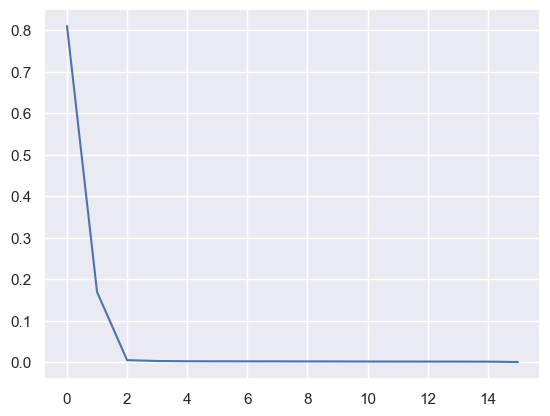

In [ ]:
plt.plot(np.arange(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.show()

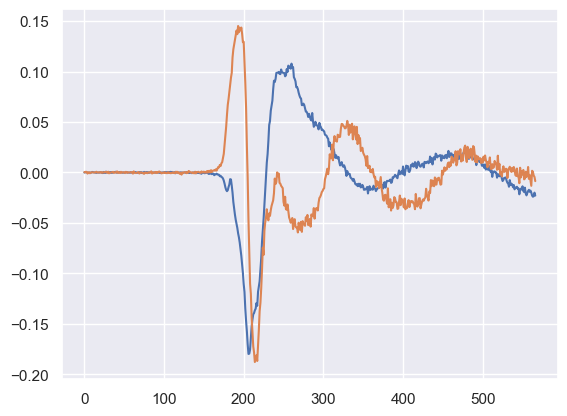

In [ ]:
plt.plot(np.arange(n_points), pca.components_[0])
plt.plot(np.arange(n_points), pca.components_[1])
# plt.plot(np.arange(n_points), pca.components_[2])
# plt.plot(np.arange(n_points), pca.components_[3])
plt.show()

In [ ]:
n_components = 3
nmf = NMF(n_components=n_components, random_state=42)
nmf.fit(test_array)

NMF(n_components=3, random_state=42)

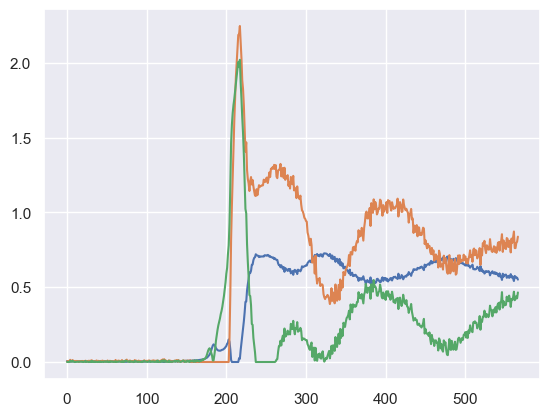

In [ ]:
plt.plot(np.arange(n_points), nmf.components_[0])
plt.plot(np.arange(n_points), nmf.components_[1])
plt.plot(np.arange(n_points), nmf.components_[2])
# plt.plot(np.arange(n_points), nmf.components_[3])
# plt.plot(np.arange(n_points), nmf.components_[4])
plt.show()

In [ ]:
test_nmf = nmf.transform(test_array)
test_nmf

array([[1.19200611, 0.3522199 , 0.        ],
       [1.18802049, 0.35386963, 0.        ],
       [1.18424526, 0.3578565 , 0.        ],
       [1.18589805, 0.35889898, 0.        ],
       [1.17330062, 0.36901899, 0.        ],
       [1.17102271, 0.36958925, 0.        ],
       [1.17340286, 0.26902932, 0.25371664],
       [1.20651773, 0.14623721, 0.50737477],
       [1.23443796, 0.12598876, 0.50687434],
       [1.26046389, 0.10644437, 0.50685069],
       [1.28491932, 0.09308224, 0.4970813 ],
       [1.3117957 , 0.07560127, 0.49053547],
       [1.36694696, 0.03764713, 0.4804311 ],
       [1.42922805, 0.        , 0.45567479],
       [1.44497877, 0.        , 0.4326426 ],
       [1.44614686, 0.        , 0.43014442]])

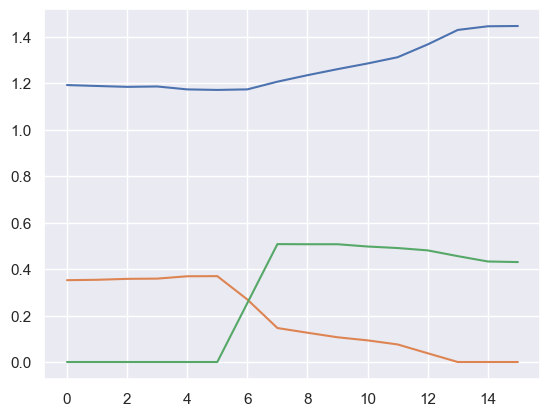

In [ ]:
for i in range(test_nmf.shape[1]):
    plt.plot(np.arange(n_measurements), test_nmf[:,i])
plt.show()

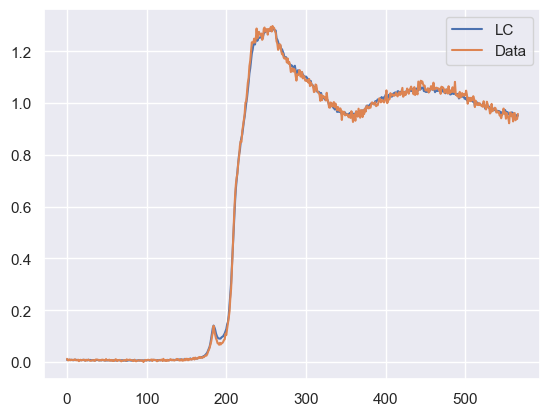

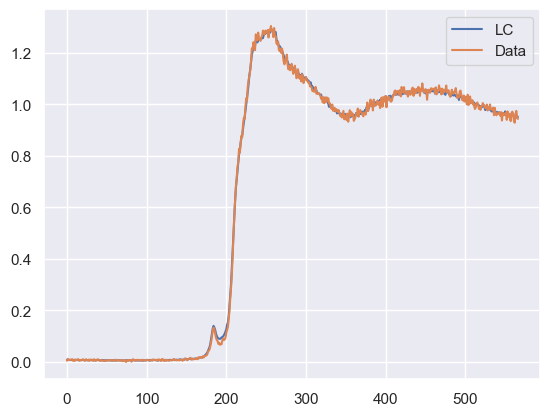

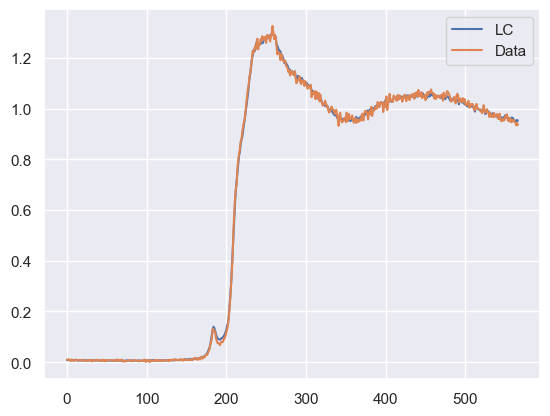

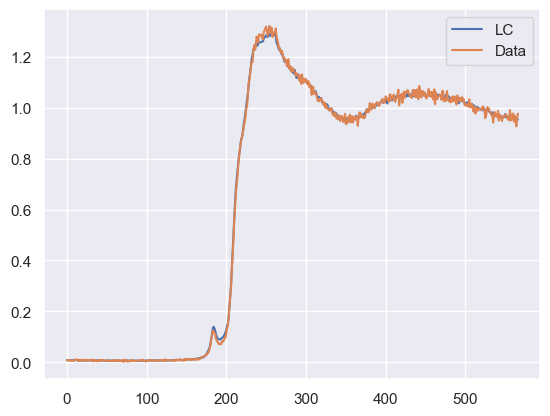

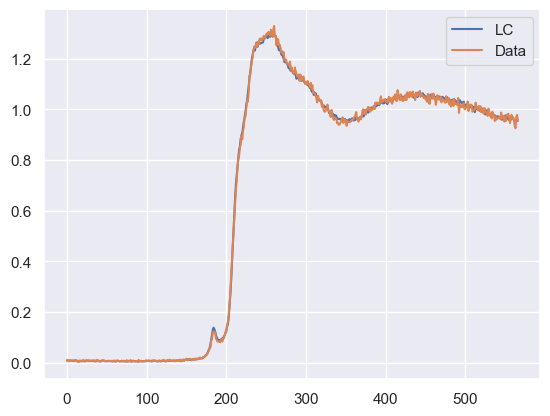

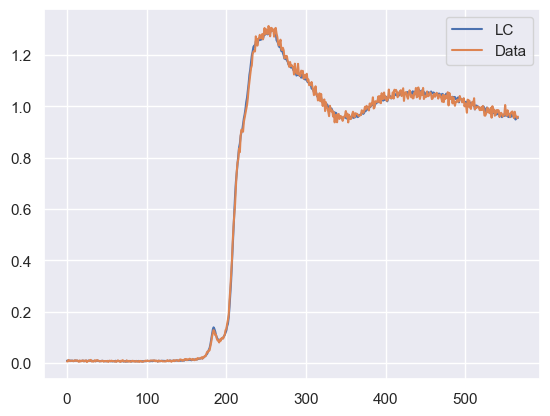

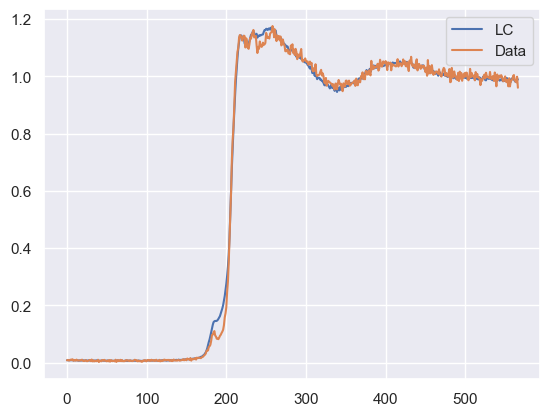

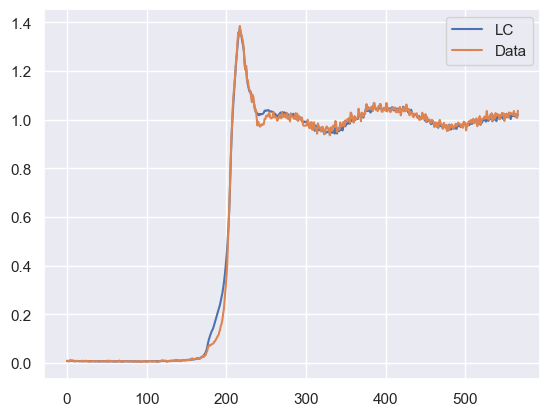

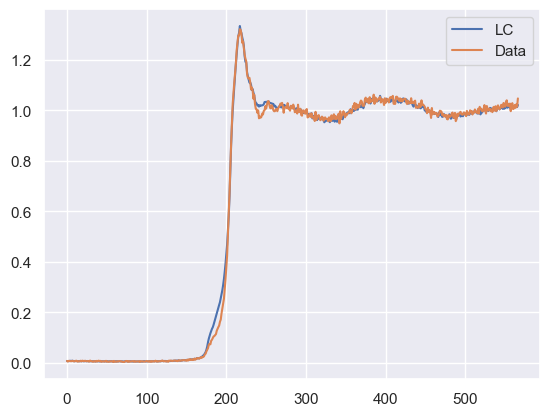

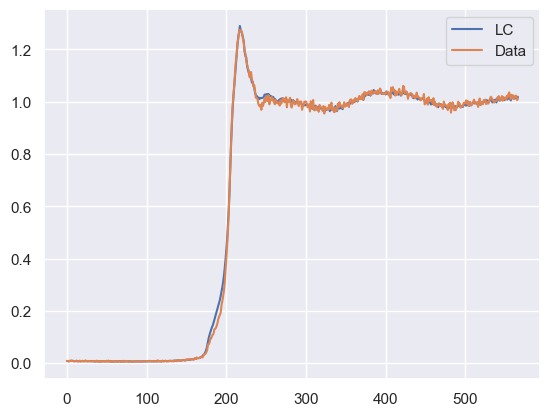

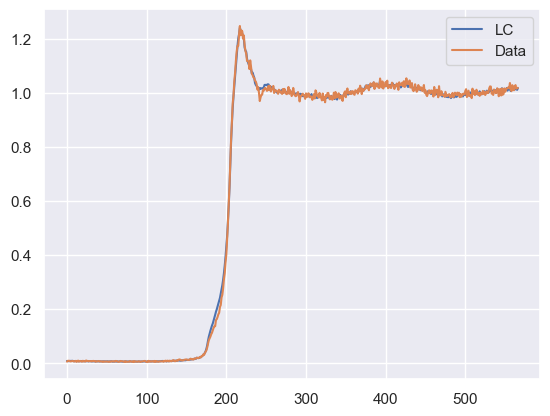

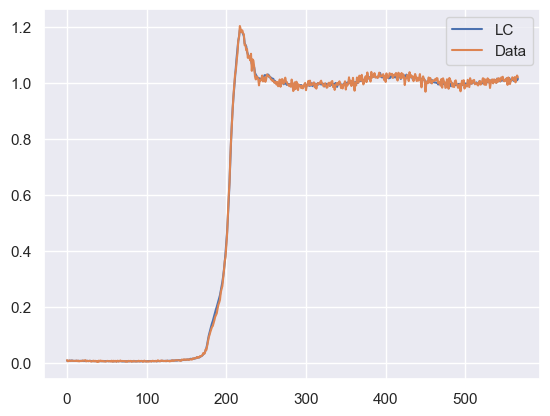

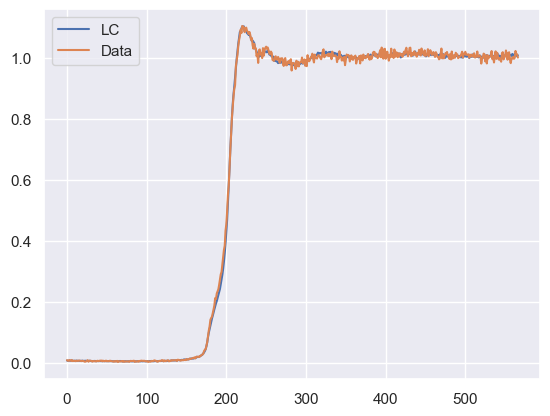

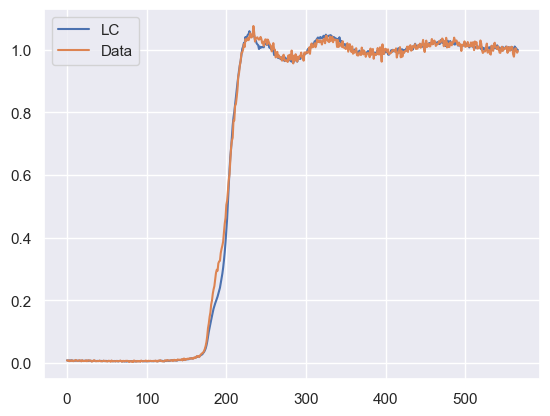

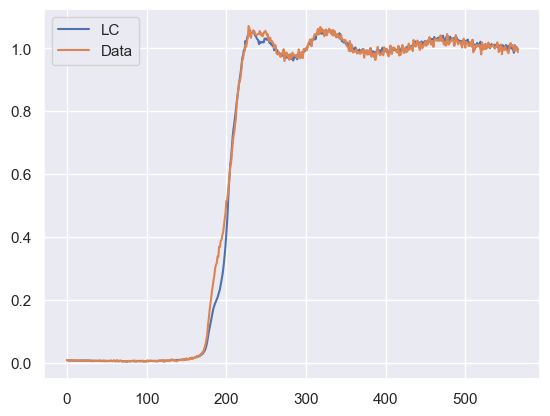

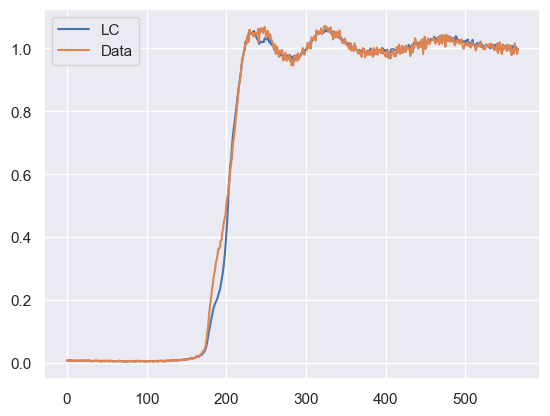

In [ ]:
for j in range(n_measurements):
    plt.plot(np.arange(n_points), np.sum([nmf.components_[i]*test_nmf[j,i] for i in range(n_components)], axis=0), label='LC')
    plt.plot(np.arange(n_points), test_array[j], label='Data')
    plt.legend()
    plt.show()

## Linear combination analysis
This section performs linear combination analysis (LCA) of every combination of two-component systems consisting of 1 metal foil and 1 precursor (with the same metal). 

The estimated uncertainties of the dependent parameter behaves weird when the independent parameter is approximately zero. In the column "StdCorrected" this is handled by using the same uncertainty for both parameters.

In [ ]:
# # LCA using measured references
# df_results = linear_combination_analysis(
#     data = df_data, 
#     products = df_foils, 
#     precursors = df_precursors,
# )
# df_results.head()

In [ ]:
# LCA using specific measurements in the experiment as references
df_results = LCA_internal(
    df_data, 
    initial_state_index = 1, 
    # intermediate_state_index = None, 
    final_state_index = -1,
)
df_results.head()

LCA progress: : 64it [00:00, 117.63it/s, Analysing frame 1 + 16]           


Experiment Metal Product Intermediate  Precursor Precursor Type  \
0  Frame 1 + last    Co    last         None          1       Internal   
1  Frame 1 + last    Co    last         None          1       Internal   
2  Frame 1 + last    Co    last         None          1       Internal   
3  Frame 1 + last    Co    last         None          1       Internal   
4  Frame 1 + last    Co    last         None          1       Internal   

   Measurement  Temperature  Temperature Average  Temperature Std  \
0            1          0.0                    0                0   
1            1          0.0                    0                0   
2            2          0.0                    0                0   
3            2          0.0                    0                0   
4            3          0.0                    0                0   

          Parameter         Value        StdErr  StdCorrected  \
0    product_weight  2.331468e-15  5.361460e-17  5.361460e-17   
1  precursor_weight  1.000000e+00  0.000000e+00  5.361460e-17   
2    product_weight  2.256247e-02  3.223006e-03  3.223006e-03   
3  precursor_weight  9.774375e-01  3.223007e-03  3.223007e-03   
4    product_weight  6.916702e-02  7.877292e-03  7.877292e-03   

                                        Energy Range  \
0  [7660.01708984375, 7660.22705078125, 7660.4726...   
1  [7660.01708984375, 7660.22705078125, 7660.4726...   
2  [7660.04541015625, 7660.26123046875, 7660.5053...   
3  [7660.04541015625, 7660.26123046875, 7660.5053...   
4  [7660.0419921875, 7660.2724609375, 7660.520507...   

                                      Basis Function  
0  [-0.0034689395105624147, -0.002025918730810221...  
1  [0.00011390603946846732, 0.001439970100124485,...  
2  [-0.0020879767840010404, -0.002032230287570082...  
3  [0.00029277049416160457, 0.001499673358537501,...  
4  [-0.002254644699275689, -0.0020473903683282213...

#### Saving results as .csv file

In [ ]:
# save_data(df_results, filename='LCA_results.csv')

### Results plotting

#### Temperature curves

In [ ]:
plot_temperatures(
    df_results, 
    with_uncertainty=True, 
    interactive=interactive
)

#### Waterfall plots


In [ ]:
plot_insitu_waterfall(
    df_data, 
    experiment='PtFeCoNi_60pct_insitu_Co_xanes', 
    # lines=[5,33,109],
    vmin=0.7, 
    vmax=1.7, 
    y_axis='Measurement',
    time_unit='m',
    interactive=interactive,
    homogenize_measurements=True,
)

In [ ]:
plot_insitu_change(
    df_data, 
    experiment='PtFeCoNi_60pct_insitu_Co_xanes', 
    reference_measurement=1,
    # lines=[5,348],
    vmin=-0.25, 
    vmax=0.25, 
    y_axis='Measurement',
    time_unit='m',
    interactive=interactive,
    homogenize_measurements=True,
)

#### Plot of a single LCA fit
Plot showing the measurement that is being fitted, the contributions from the components and the residual.

In [ ]:
plot_LCA(
    df_results, 
    df_data, 
    experiment='Frame 1 + last', 
    metal='Co',
    measurement=5, 
    interactive=interactive
)

#### Plot of LCA component weights over time
Plot showing how the weight of each component changes over time.

In [ ]:
plot_LCA_change(df_results, product='last', precursor=1, metal='Co', x_axis='Measurement', with_uncertainty=True, interactive=interactive)

#### Comparison of reduction times of different metals
Plot showing the weight of the metal foil component over time for the different metal species in the sample. 

In [ ]:
plot_reduction_comparison(
    df_results, 
    precursor_type='all', 
    x_axis='Measurement', 
    with_uncertainty=True, 
    interactive=interactive
)